In [1]:
# TO BE RUN ONLY ONCE!
import os
os.chdir("../")

In [2]:
## *******************************************************************************

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

import spatial_mix.hdp_utils as hdp_utils
from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

## Simulate data

<img src="simulation_scenario.png">

Simulate data as follows: for each little square we simulate data from a 3 components mixtures
$$ y_{ij} \sim w_{i1} N(-5, 1) + w_{i2} N(0, 1) + w_{i3} N(5, 1)$$

the weights depend on the location (x, y) of the center of the square (the orange dot)
$$ \widetilde{w}_{il} = \alpha_l x_i + \beta_l y_i \quad l=1, 2$$

finally $w_i = alr^{-1} ([\widetilde{w}_{i1}, \widetilde{w}_{i2}])$

In [4]:
def inv_alr(x):
    out = np.exp(np.hstack((x, 1)))
    return out / np.sum(out)

In [5]:
def simulate_from_mixture(weights):
    means = [-5, 0, 5]
    comp = np.random.choice(3, p=weights)
    return np.random.normal(loc=means[comp], scale=1)

In [ ]:
centers = np.array([[0, 1], [1, 1], [2, 1], [3, 1], [0, 0], [1, 0], [2, 0], [3, 0]])
centers = centers / 10
alpha1 = 0.3
alpha2 = -0.3
beta1 = 0.3
beta2 = -0.3

weights = []
for center in centers:
    w1 = alpha1 * center[0] + beta1 * center[1]
    w2 = alpha2 * center[0] + beta2 * center[1]
    weights.append(inv_alr([w1, w2]))

In [ ]:
Dmat1 = np.zeros((8, 8))

for i in range(7):
    Dmat1[i, i+1] = 1
    Dmat1[i+1, i] = 1
    if (i < 4):
        Dmat1[i, i+4] = 1
        Dmat1[i+4, i] = 1
    
print(Dmat1)

In [ ]:
np.savetxt("data/simulated_D1.csv", Dmat1, delimiter=",")

In [ ]:
data = []
for i in range(8):
    numSamples = 100
    if i == 5:
        numSamples = 20
        
    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i])])

In [ ]:
df = pd.DataFrame(data, columns=["group", "data"])
df.to_csv("data/simulated_data1.csv", index=False)

# Simulated Scenario 2

In [6]:
Dmat2 = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
]) 

print(Dmat2)

[[0 1 1 1 0 0 0 0]
 [1 0 1 1 0 0 0 0]
 [1 1 0 1 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 1 1 0 1]
 [0 0 0 0 1 1 1 0]]


In [7]:
w_group1 = np.array([0.25, 0.25, 0.5])
w_group2 = np.array([0.4, 0.4, 0.2])

weights = []

data = []
for i in range(8):
    numSamples = 1000
#     if i == 5:
#         numSamples = 20
    
    w = w_group1 if i < 4 else w_group2
    weights.append(w)
    for j in range(numSamples):
        data.append([i, simulate_from_mixture(w)])
        
df = pd.DataFrame(data, columns=["group", "data"])
df.to_csv("data/simulated_data2.csv", index=False)
np.savetxt("data/simulated_D2.csv", Dmat2, delimiter=",")

# call C++ from terminal

In [9]:
subprocess.call(
    "./spatial_mix/run_from_file.out"
    " data/simulated_data2.csv"
    " data/simulated_D2.csv"
    " data/chains_simulated2.recordio".split())

0

In [ ]:
print("./spatial_mix/run_from_file.out"
    " data/simulated_data2.csv"
    " data/simulated_D2.csv"
    " data/chains_simulated2.recordio")

## Plot density estimates

In [10]:
df = pd.read_csv("data/simulated_data2.csv")
chains = loadChains("data/chains_simulated2.recordio")

In [11]:
datas = []
for g in range(8):
    datas.append(df[df.group == g].data.values)

In [12]:
xgrid = np.linspace(-10, 10, 1000)
dens = estimateDensities(chains, xgrid)

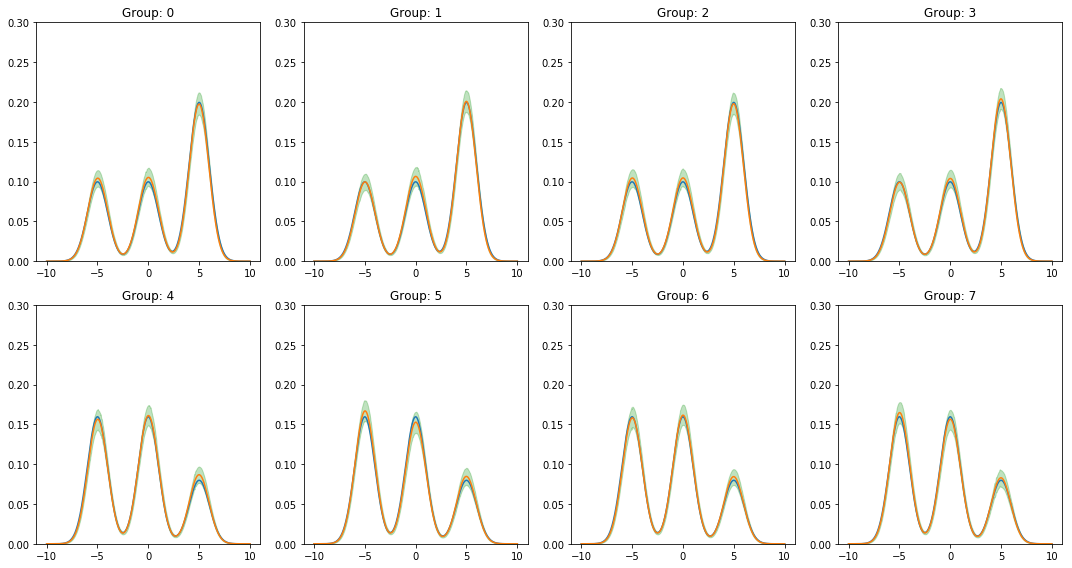

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    axes[g].set_ylim([0, 0.3])
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
#     sns.kdeplot(datas[g], ax=axes[g], color=current_palette[3])
    
plt.tight_layout()

In [ ]:
estimateds = estimateDensities(chains, datas)
lpml(estimateds)

In [14]:
chains[0].rho

0.8739367499722547

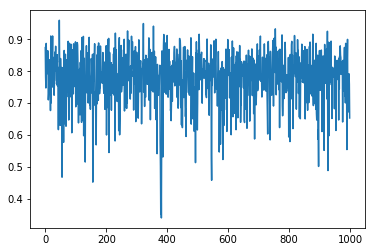

In [16]:
## Plot RhoChain
rhoChain = list(map(lambda x: x.rho, chains))
plt.plot(range(len(chains)), rhoChain)

## Hdp

In [ ]:
subprocess.call(
    "./spatial_mix/run_hdp_from_file.out"
    " data/simulated_data2.csv"
    " data/chains_hdp_simulated2.recordio".split())

In [ ]:
hdpChains = loadChains("data/chains_hdp_simulated2.recordio", HdpState)

In [ ]:
xgrid = np.linspace(-10, 10, 1000)
densHdp = hdp_utils.estimateDensities(hdpChains, xgrid)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
    obs = df[df["group"] == g]["data"].values
    # sns.kdeplot(obs, ax=axes[g])
    axes[g].set_ylim([0, 0.3])
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    intervals = np.array([pm.stats.hpd(densHdp[g][:, i], 0.05) for i in range(densHdp[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
    
plt.tight_layout()

In [ ]:
estimatedHdp = hdp_utils.estimateDensities(hdpChains, datas)
lpml(estimatedHdp)

In [ ]:
lpml(estimatedHdp[2])

In [ ]:
lpml(estimateds[2])